In [1]:
# general imports
import sys
sys.path.append("/home/ismini/FastEMRIWaveforms")
sys.path.append("/home/ismini/FastEMRIWaveforms/EMRI_FrequencyDomainWaveforms-main/")
print(sys.path)

import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mpmath

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils import *


['/home/ismini/FastEMRIWaveforms/acer_work', '/home/ismini/anaconda3/envs/few_env/lib/python310.zip', '/home/ismini/anaconda3/envs/few_env/lib/python3.10', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/lib-dynload', '', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages', '/home/ismini/FastEMRIWaveforms', '/home/ismini/FastEMRIWaveforms/EMRI_FrequencyDomainWaveforms-main/']


In [2]:
# additional imports
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

from mpmath import *
from scipy.integrate import DOP853
import scipy

# import HaloFeedback (version with additional dLdt evaluation)
#from HaloFeedbackdLdt_ecc import DistributionFunction, PowerLawSpike, PlateauSpike
from Final_HaloFeedback import DistributionFunction, PowerLawSpike

#from fastinterp import *

import time
import warnings
from abc import ABC, abstractmethod
from time import time as timeit

import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import quad, simps
from scipy.interpolate import interp1d
from scipy.special import ellipeinc, ellipkinc, ellipe, ellipk, betainc
from scipy.special import gamma as Gamma
from scipy.special import beta as Beta

import pandas as pd 

In [3]:
# settings for the elliptic integrals
mp.dps = 25
mp.pretty = True

# settings for the waveform
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # 0 (1) we (don't) want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
#from few.utils.utility import omp_set_num_threads
#omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [4]:
# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

### Gravitational Wave losses

In [5]:
def Edot_GW(p,e):
    # Azimuthal frequency
    Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

    # Post-Newtonian calculations
    yPN = pow(Omega_phi,2./3.)

    EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
    LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)
    return EdotPN, LdotPN


In [6]:
def dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp):
        """Rate of change of energy due to DF (km/s)^2 s^-1 M_sun.
        Use to find the energy losses from one set of (p,e, gamma) to the next.

        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
        """
        pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        r_sp = (((3-gamma)* 0.2**(3-gamma) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dEdt = (1 / pc_to_km) * (2*(1 - e**2)**(3/2) * G_N**(3/2) * mu**2 * rho_sp * 0.58 * r_sp**(gamma) * CoulombLog)/(np.sqrt(M) * p_pc**(gamma -1/2))

        def integrand_E(theta):

            #return dEdt * (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)
            return (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)    
        
        result_E, error_E = quad(integrand_E, 0.0, 2 * np.pi)
        E_dot_DF = dEdt * result_E * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
        return (E_dot_DF)


def dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp):
        """Rate of change of angular momentum in [(km/s)^2 M_sun].
        Use to find the angular momentum losses from one set of (p,e, gamma) to the next.
    
        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
        """
        # pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        r_sp = (((3-gamma)* 0.2**(3-gamma) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dLdt = (2 * (1 - e**2)**(3/2) * G_N * mu**2 * rho_sp * 0.58 * r_sp**(gamma) * CoulombLog)/(M* p_pc**(gamma -2))

        def integrand_L(theta):

            return (1 + e * np.cos(theta))**(gamma-2) / (1 + 2 * e * np.cos(theta) + e**2)**(3/2)
    
        result_L, error_L = quad(integrand_L, 0.0, 2 * np.pi)
        L_dot_DF = dLdt * result_L * 10**6 /Power(C_SI,2)

        return (L_dot_DF)


### Circular vs Eccentric Dynamical Friction losses

In [7]:
# this just verifies the elliptic DF losses for e=0 match the circular and the circular without considering any changes in the density

def Edot_DF_circ(p_init, e_init, p, e, M, mu, gamma_sp, rho_sp, Lambda=-1):
    p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

    DMS = PowerLawSpike(p_init, e_init, p, e, M, mu, gamma_sp, rho_sp, Lambda=-1)

    r_apo = DMS.r_apo(p, e)
    # rho_apo = DMS.rho(p_pc)
    # rho_apo_init = DMS.rho_init(p_pc)

    Edot_DF_circ = DMS.dEdt_DF(r_apo) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    Edot_DF_circ_new = DMS.dEdt_circular(p, e) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    # dEdt_DF_ecc_evol feeds with p in pc 
    Edot_DF_ecc = dEdt_DF_ecc(M, mu, p, e, gamma_sp, rho_sp)
    
    Ldot_DF_ecc = dLdt_DF_ecc(M, mu, p, e, gamma_sp, rho_sp)

    return Edot_DF_circ, Edot_DF_circ_new, Edot_DF_ecc, Ldot_DF_ecc


[0.99922804 0.99923213 0.99923621 0.99924028 0.99924434 0.99924838
 0.99925242 0.99925644 0.99926045 0.99926445 0.99926844 0.99927241
 0.99927638 0.99928033 0.99928427 0.9992882  0.99929211 0.99929602
 0.99929991 0.9993038  0.99930767 0.99931152 0.99931537 0.99931921
 0.99932303 0.99932684 0.99933064 0.99933443 0.99933821 0.99934197
 0.99934572 0.99934946 0.99935319 0.99935691 0.99936062 0.99936431
 0.999368   0.99937167 0.99937533 0.99937897 0.99938261 0.99938624
 0.99938985 0.99939345 0.99939704 0.99940062 0.99940418 0.99940774
 0.99941128 0.99941481 0.99941833 0.99942184 0.99942533 0.99942882
 0.99943229 0.99943575 0.9994392  0.99944264 0.99944606 0.99944948
 0.99945288 0.99945627 0.99945965 0.99946302 0.99946637 0.99946972
 0.99947305 0.99947637 0.99947968 0.99948297 0.99948626 0.99948953
 0.9994928  0.99949605 0.99949929 0.99950251 0.99950573 0.99950893
 0.99951212 0.99951531 0.99951847 0.99952163 0.99952478 0.99952791
 0.99953103 0.99953414 0.99953724 0.99954033 0.99954341 0.9995

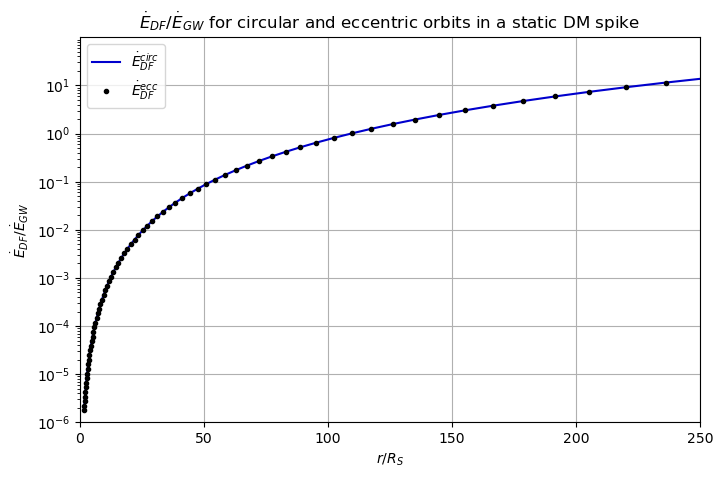

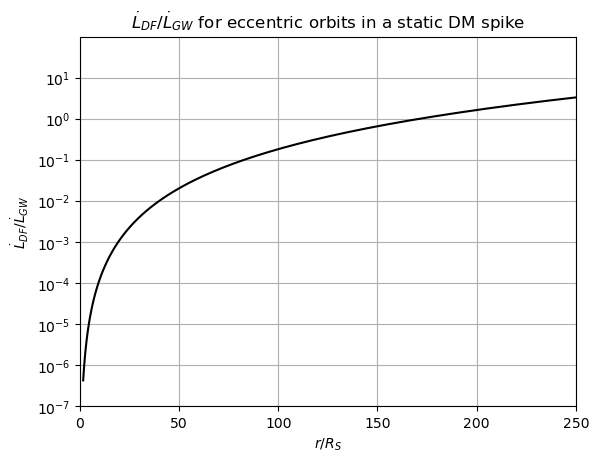

In [8]:
# Testing the losses for eccentric spike vs circular spike without feedback
ptest = 10**np.linspace(1, 4, 100)
M = 1e5 # M_sun
mu = 1e1 # M_sun
rho_sp = 226 # M_sun pc^-3
gamma_sp = 7/3
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


Edot_circ = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp)[0]/Edot_GW(pp,0.0)[0] for pp in ptest])
Edot_circ_new = np.asarray([Edot_DF_circ(pp, 0.0, pp, 0.0, M, mu, gamma_sp, rho_sp)[1]/Edot_GW(pp, 0.0)[0] for pp in ptest])
Edot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp)[2]/Edot_GW(pp,0.0)[0] for pp in ptest])
Ldot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp)[3]/Edot_GW(pp,0.0)[1] for pp in ptest])

print(Edot_circ/Edot_ecc)

plt.figure(figsize=(8,5))
plt.title('$\dot{E}_{DF}/\dot{E}_{GW}$ for circular and eccentric orbits in a static DM spike')
plt.semilogy(ptest/6, Edot_circ, label='$\dot{E}_{DF}^{circ}$' , color = 'mediumblue')
#plt.semilogy(ptest/6, Edot_circ_new, color='r')
plt.semilogy(ptest/6, Edot_ecc, '.', label='$\dot{E}_{DF}^{ecc}$', color='k')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-6), 100])
plt.yticks([10**i for i in range(-6, 2)])
plt.legend()
plt.show()

plt.figure()
plt.title('$\dot{L}_{DF}/\dot{L}_{GW}$ for eccentric orbits in a static DM spike')
plt.semilogy(ptest/6, Ldot_ecc, color = 'k')
plt.ylabel('$\dot{L}_{DF}/\dot{L}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-7), 100])
plt.yticks([10**i for i in range(-7, 2)])
plt.show()


This confirms the validity of eccentric losses in the circular case (i.e.  $e=0$)

### Dynamical Friction losses
This way we can obtain the DF losses for eccentric orbits in a static DM spike witout using HaloFeedback.

### Trajectory module for static spikes and eccentric orbits

In [9]:
# this is class object just to hold epsilon, M, mu, rho_sp, r_sp and gamma as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class DF:
    def __init__(self, epsilon, M, mu, gamma, rho_sp):
        self.epsilon = epsilon
        self.M = M
        self.mu = mu
        self.rho_sp = rho_sp
        self.gamma = gamma


    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon
        M = self.M
        mu = self.mu
        rho_sp = self.rho_sp
        gamma = self.gamma
        
        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y

        # guard against bad integration steps
        if e >= 1.0 or p < 6.0 or (p - 6 - 2* e) < 0.05:
#             print('bad', y)
            return [0.0, 0.0, 0.0, 0.0]
        if e<1e-5:
            e = 1e-5

        # Azimuthal frequency
        # perform elliptic calculations
        Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

        # GW
        EdotPN,LdotPN = Edot_GW(p,e)

        # dynamical friction parameters
        EdotDF = dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp)
        LdotDF = dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp)

        # flux
#         print(EdotDF/EdotPN)
        Edot = -epsilon*(EdotPN + EdotDF )
        Ldot = -epsilon*(LdotPN + LdotDF )
        
        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = Omega_r;
        
        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]
            
        if e<=1e-5:
            dydt[1] = 0.0

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class DFTrajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, T=1.0, dt=10.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M

        M = M
        mu = mu
        gamma_sp = args[0]
        rho_sp = args[1]
        
        rhs = DF(epsilon, M, mu, gamma_sp, rho_sp)
        #print(rhs)

        # the tolerance is important!
        integrator = DOP853(rhs, 0.0, y0, T,  rtol=1e-10, atol=1e-10, first_step=dt/Msec)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:

            integrator.step()
            
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)
           
            if (p - 6 -2*e) < 0.05:
                run = False


        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    

static_traj = DFTrajectory()

### No spike from the static spike trajectory

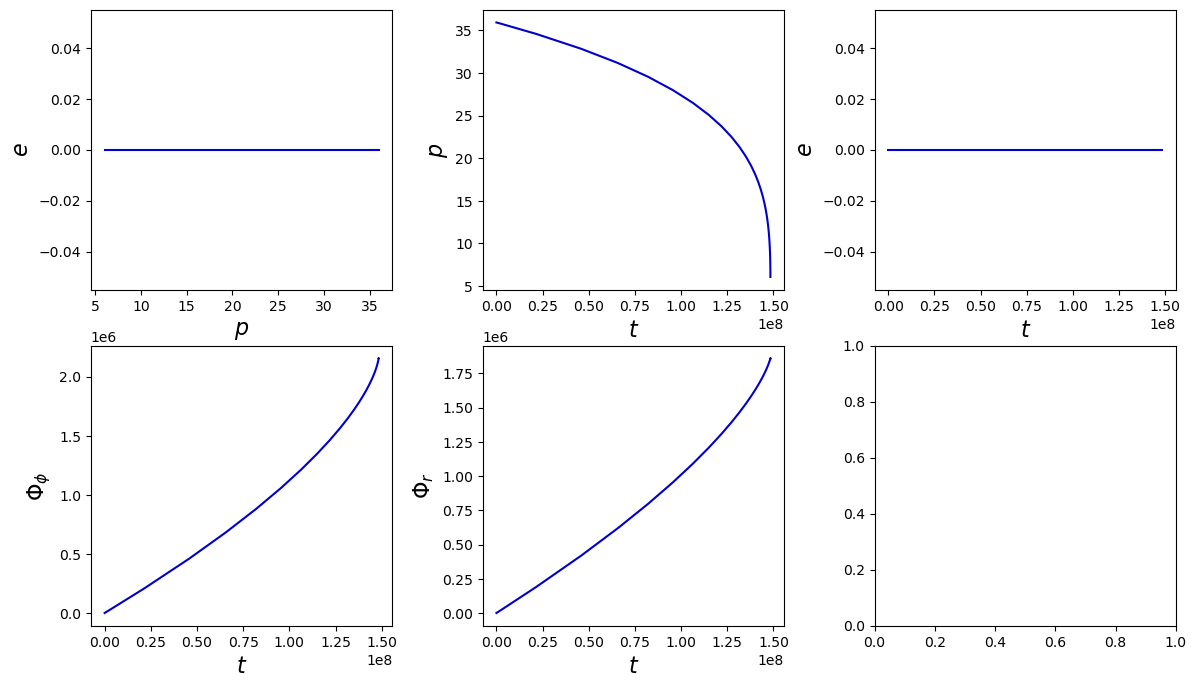

In [10]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 1e-100

no_static_spike_traj = static_traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, T=T, dt=10.0)
t_no_st_sp, p_no_st_sp, e_no_st_sp, x_no_st_sp, Phi_phi_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp = no_static_spike_traj
# spline the results
no_static_spike_spline = CubicSplineInterpolant(t_no_st_sp, np.stack((p_no_st_sp, e_no_st_sp, x_no_st_sp, Phi_phi_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_no_st_sp, p_no_st_sp, e_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp]
xs = [p_no_st_sp, t_no_st_sp, t_no_st_sp, t_no_st_sp, t_no_st_sp]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='mediumblue')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

### Static spike trajectory

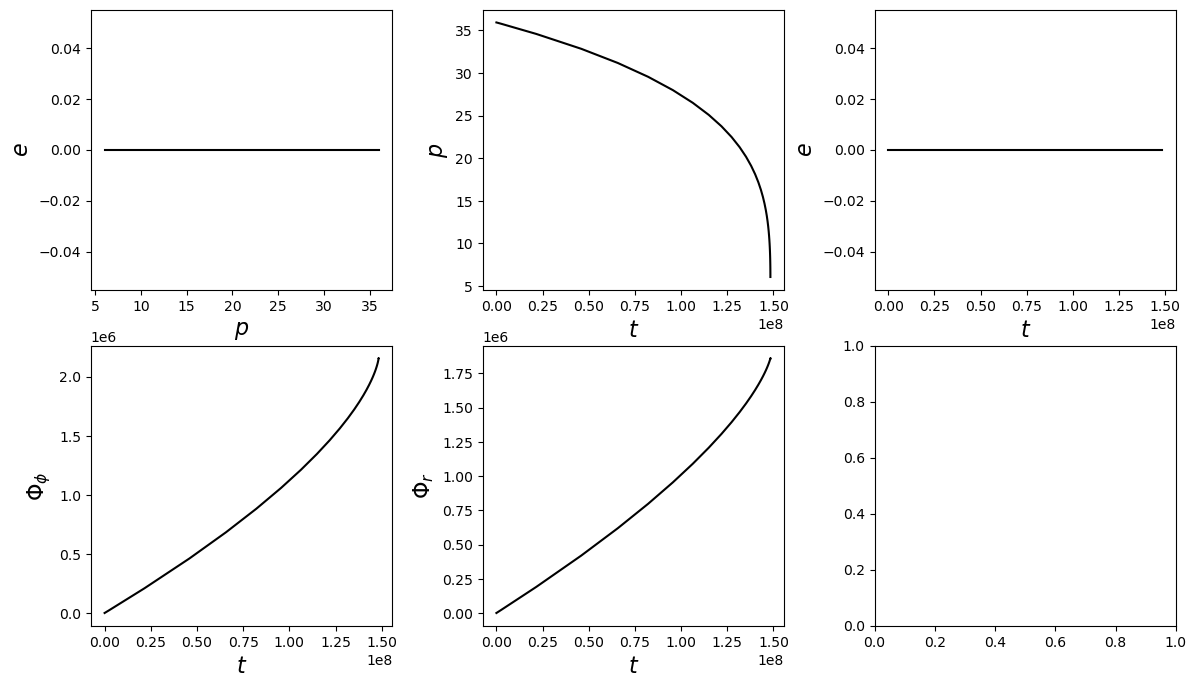

In [11]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226

static_spike_traj = static_traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, T=T, dt=10.0)
t_st_sp, p_st_sp, e_st_sp, x_st_sp, Phi_phi_st_sp, Phi_theta_st_sp, Phi_r_st_sp = static_spike_traj
# spline the results
static_spike_spline = CubicSplineInterpolant(t_st_sp, np.stack((p_st_sp, e_st_sp, x_st_sp, Phi_phi_st_sp, Phi_theta_st_sp, Phi_r_st_sp)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_st_sp, p_st_sp, e_st_sp, Phi_theta_st_sp, Phi_r_st_sp]
xs = [p_st_sp, t_st_sp, t_st_sp, t_st_sp, t_st_sp]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'p')

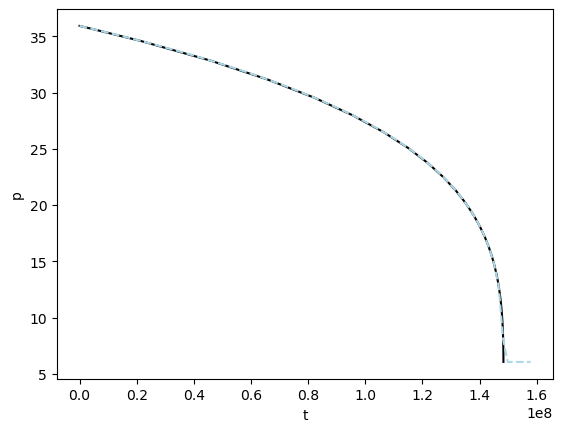

In [12]:
plt.plot(t_st_sp, p_st_sp, color='k')
newt = np.linspace(0.0, T*YRSID_SI,num=100)

plt.plot(newt, static_spike_spline(newt)[0],'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, 'Number of cycles')

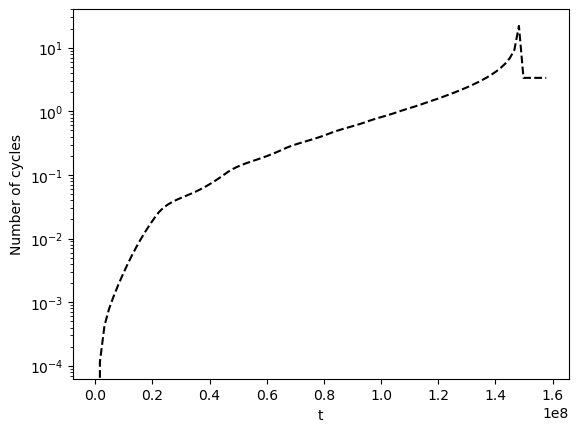

In [13]:
plt.figure()
# the time is store in the spline
plt.semilogy(newt, np.abs(no_static_spike_spline(newt)[4]-static_spike_spline(newt)[4])/(2*np.pi),'--', color='k')
plt.xlabel('t')
plt.ylabel('Number of cycles')
# should be similar to fig 5 https://arxiv.org/pdf/2211.01362.pdf

To get the deppasing as a function of frequency.

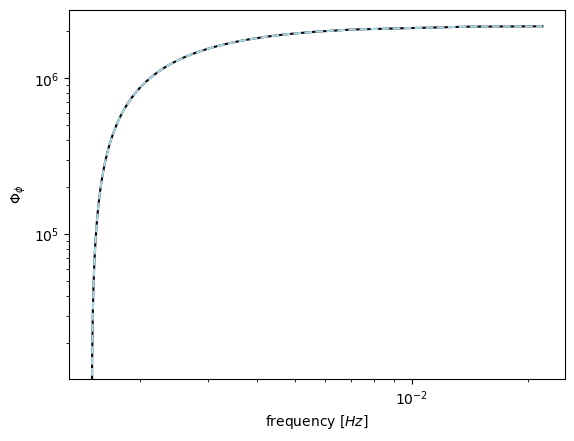

/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages/few/summation/interpolatedmodesum.py:217: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  warnings.warn(


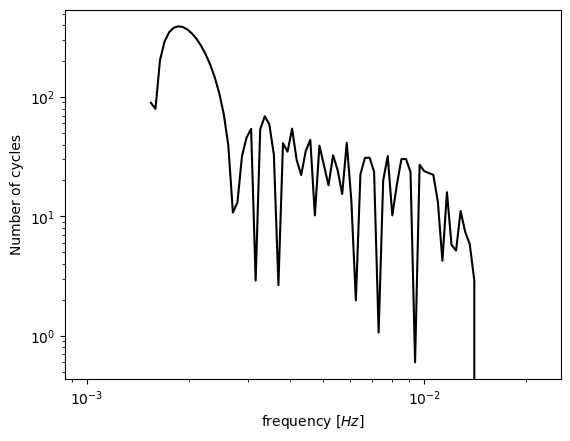

In [14]:
# no spike
no_stat_sp_ff = no_static_spike_spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
no_stat_sp_phase = no_static_spike_spline(newt)[4]
no_stat_sp_spl_phase = CubicSplineInterpolant(no_stat_sp_ff, no_stat_sp_phase)
# spike
ff_stat_sp = static_spike_spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase_stat_sp = static_spike_spline(newt)[4]
stat_sp_spl_phase = CubicSplineInterpolant(ff_stat_sp, phase_stat_sp)

freq = 10**np.linspace(-3,np.log10(np.max(no_stat_sp_ff)),num=100)

plt.figure()
# the time is store in the spline
plt.loglog(no_stat_sp_ff, no_stat_sp_phase, color='k')
plt.loglog(ff_stat_sp, phase_stat_sp,'--', color='lightblue')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\phi}$')
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(no_stat_sp_spl_phase(freq)-stat_sp_spl_phase(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

These two functions give the energy and angular momentum losses for eccentric trajectories and evolving spikes. The difference with the ones used previously is an additional factor $(1 - \frac{\delta \rho}{\rho_{init}})$ which accounts for the difference in the density after each step of the integrator.

In [15]:
def dEdt_DF_ecc_evol(M, mu, p, e, gamma, rho_sp, evol_factor_apo):
        """Rate of change of energy due to DF (km/s)^2 s^-1 M_sun.
        Use to find the energy losses from one set of (p,e, gamma) to the next.

        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - evol_factor: (1 - drho/rho_init) [dim/les] -- such that rho_f = rho_init * (1 - drho/rho_init)
        """
        pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        r_sp = (((3-gamma)* 0.2**(3-gamma) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dEdt = (1 / pc_to_km) * (2*(1 - e**2)**(3/2) * G_N**(3/2) * mu**2 * rho_sp * 0.58 * evol_factor_apo * r_sp**(gamma) * CoulombLog)/(np.sqrt(M) * p_pc**(gamma -1/2))

        def integrand_E(theta):

            #return dEdt * (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)
            return (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)    
        
        result_E, error_E = quad(integrand_E, 0.0, 2 * np.pi)
        E_dot_DF = dEdt * result_E * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
    
        return (E_dot_DF)

def dLdt_DF_ecc_evol(M, mu, p, e, gamma, rho_sp, evol_factor_apo):
        """Rate of change of angular momentum in [(km/s)^2 M_sun].
        Use to find the angular momentum losses from one set of (p,e, gamma) to the next.
    
        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - evol_factor: (1 - drho/rho_init) [dim/les] -- such that rho_f = rho_init * (1 - drho/rho_init)
        """
        # pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        r_sp = (((3-gamma)* 0.2**(3-gamma) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dLdt = (2 * (1 - e**2)**(3/2) * G_N * mu**2 * rho_sp * 0.58 * evol_factor_apo * r_sp**(gamma) * CoulombLog)/(M* p_pc**(gamma -2))

        def integrand_L(theta):

            return (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / (1 + 2 * e * np.cos(theta) + e**2)**(3/2)
    
        result_L, error_L = quad(integrand_L, 0.0, 2 * np.pi)
        L_dot_DF = dLdt * result_L * 10**6 /Power(C_SI,2)

        return (L_dot_DF)


### Evoliving the spike
Here we make use of the HaloFeedback to evolve the DM denstity between each step $(p,e)$ of the integrator.

In [16]:
def spike_evolution(p0, e0, t0, p, e, t, M, mu, rho_sp, gamma_sp, evol_factor_init, DMS = None):
    # use any function of Final_HaloFeedback.py as DMS.

    # unit conversions
    pc_to_km = 3.08567758149137e13

    SPEED_CUT = True

    if DMS is None:
        DMS = PowerLawSpike(p0, e0, p, e, M=M, mu=mu, gamma=gamma_sp, rho_sp=rho_sp, Lambda=-1)

    r0_apo = DMS.r_apo(p0, e0) # initial apocenter in pc
    r0_peri = DMS.r_apo(p0, e0) # initial pericenter in pc
    v0_ecc_apo = DMS.v_ecc_apo(p0, e0) # initial velocity of the CO in km/s

    v_cut = -1 # to use functions of Final_HaloFeedback
    if SPEED_CUT:
        v_cut = v0_ecc_apo

    r_apo = DMS.r_apo(p, e) # apocenter in pc
    r_peri = DMS.r_peric(p, e) # pericenter in pc
    
    v_ecc_apo = DMS.v_ecc_apo(p, e) # velocity of the CO at final apocenter in km/s
    v_ecc_peri = DMS.v_ecc_peri(p, e) # velocity of the CO at final pericenter in km/s

    T_orb = 2 * np.pi * r0_apo * pc_to_km / v0_ecc_apo # orbital time in sec
    
    N_orb = int((t - t0)/T_orb) # Number of orbits within (|p_i - p_i+1|, |e_i - e_i+1|) to evolve
    if N_orb >= 10000:
        orbits_per_step = 500
    elif N_orb >= 1000 and N_orb < 10000:
        orbits_per_step = 100
    elif N_orb >= 100 and N_orb < 1000:
        orbits_per_step = 50
    else:
        orbits_per_step = 10
        
    N_step = int(N_orb / orbits_per_step)

    if N_step <= 1:
        N_step = 2 

    # EMRI cycles are aprox. 10^4 - 10^5
    # the CO will pass many times from the same radii for eccentric orbits

    dt = T_orb * orbits_per_step # in sec
    t_list = dt * N_step * np.linspace(0, 1, N_step + 1)
    # print('t_list = ', t_list)

    print('Number of orbits = ', N_orb)
    print('Total time [days] = ', N_step*dt/(3600*24))

    # radial grid for calculating the density
    N_r = 100 
    r_list = np.linspace(r0_apo, r_peri, N_r - 1)
    r_list = np.sort(np.append(r_list, r_apo))
    # print('r_list = ', r_list)

    # initialize rho_list with correct dimensionality
    rho_list = np.zeros((N_step + 1, N_r))

    # extract the index of r_apo 
    # (that is where we will get the evol_factor 
    # and feed it to dEdt_DF_ecc_evol) 
    r_apo_ind = np.where(r_list == r_apo)[0][0]
    # print('r_apo_ind = ', r_apo_ind)

    M_dm_list = np.zeros(N_step-1)
    M_dm_list[0] = DMS.TotalMass()

    # using the proper dEdtDF
    DF_list = np.zeros(N_step)
    DF_list[0] = DMS.dEdt_DF(r0_apo, v_cut)

    E_list = np.zeros(N_step)
    E_list[0] = DMS.TotalEnergy()

    E_ej_tot = 0.0 * t_list

    if SPEED_CUT: 
        rho_init = np.array([DMS.rho(r, v_ecc_apo) for r in r_list])

    # we need to multiply the density at each point with the evol_factor to get the updated value from the orbits performed during the previous step of the integrator     
    rho_list[0, :] = rho_init * evol_factor_init

    # following HaloFeedback 
    for i in range(N_step):
        if SPEED_CUT:
             rho_list[i, :] = np.array([DMS.rho(r, v0_ecc_apo) for r in r_list])

        M_dm_list[i-1] = DMS.TotalMass()

        E_ej_tot[i] = E_ej_tot[i-1] + DMS.dEdt_ej(v_orb=v0_ecc_apo, v_cut=v_cut) * dt

        df1 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += df1
        df2 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += 0.5 * (df2 - df1)

        E_list[i] = DMS.TotalEnergy()

        DF_list[i] = DMS.dEdt_DF(r0_apo, v_cut)

    # get the initial and final density and their difference at r_apo
    r_apo = r_list[r_apo_ind]
    rho_apo_init = rho_list[0, r_apo_ind]
    # print('rho_apo_init = ', rho_apo_init)
    rho_apo_evol = rho_list[-2, r_apo_ind]
    # print('rho_apo_evol = ', rho_apo_evol)
    drho_apo = np.abs(rho_apo_init-rho_apo_evol)

    drho_list = np.abs(rho_list[0,:] - rho_list[-2,:])
    # print('drho_list =', drho_list)

    # get the evol_factor_apo that will bw used by dEdt_DF_ecc_evol and dLdt_DF_ecc_evol
    evol_factor_apo = 1 - (drho_apo/rho_apo_init)
    # print('evol_factor_apo = ', evol_factor_apo)

    # get the evol_factor for all radii between r0_apo and r_peri
    evol_factor_orig = 1 - (drho_list/rho_list[0,:])
    # print('evol_factor_orig =', evol_factor_orig)

    # get the evol_factor for all radii between r_apo and the pericenter of the next step
    apo_index = np.where(evol_factor_orig==evol_factor_apo)[0][0]
    evol_factor = evol_factor_orig[apo_index:]
    
    # append ones for the undisturbed radii (i.e. the radii in (r_peri, r_peri_next), where r_peri_next refers to the upcoming r_peri at the next step of the integrator
    if len(evol_factor) != N_r:
        number_of_ones = N_r - len(evol_factor)
        evol_factor += [1] * number_of_ones

    # get the DF energy losses for circular orbits from HaloFeedback for comparisons
    dEdt_DF_circ = DF_list[r_apo_ind]
    # print('dEdt_DF_circ = ', dEdt_DF_circ * 10**6 /(Power(C_SI,2) * MTSUN_SI * M))

    return evol_factor_apo, evol_factor, dEdt_DF_circ



### This is the actual trajectory class that can be used to produce GWs of EMRIs embedded in dynamic spikes.

In [17]:
# this is class object just to hold epsilon, M, mu, rho_sp and gamma_sp as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class DF_evol:
    def __init__(self, epsilon, M, mu, rho_sp, gamma_sp):
        self.epsilon = epsilon
        self.M = M
        self.mu = mu
        self.rho_sp = rho_sp
        self.gamma_sp = gamma_sp

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon
        M = self.M
        mu = self.mu
        rho_sp = self.rho_sp
        gamma_sp = self.gamma_sp
        
        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        evol_factor_apo = self.evol_factor_apo

        # guard against bad integration steps
        if e >= 1.0 or p < 6.0 or (p - 6 - 2* e) < 0.05:
#             print('bad', y)
            return [0.0, 0.0, 0.0, 0.0]
        if e<1e-5:
            e = 1e-5

        # Azimuthal frequency
        # perform elliptic calculations
        Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

        # GW
        EdotPN, LdotPN = Edot_GW(p,e)

        # dynamical friction parameters
        EdotDF = dEdt_DF_ecc_evol(M, mu, p, e, gamma_sp, rho_sp, evol_factor_apo)
        LdotDF = dLdt_DF_ecc_evol(M, mu, p, e, gamma_sp, rho_sp, evol_factor_apo)

        # flux
        Edot = -epsilon*(EdotPN + EdotDF)
        Ldot = -epsilon*(LdotPN + LdotDF)
        
        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = Omega_r;
        
        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]
            
        if e<=1e-5:
            dydt[1] = 0.0

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class DF_evol_Trajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, T=1.0, dt=10.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M

        M = M
        mu = mu
        gamma_sp = args[0]
        rho_sp = args[1]
        evol_factor_init = args[2]
        p_init = p0
        e_init = e0
        t_init = 0

        rhs = DF_evol(epsilon, M, mu, rho_sp, gamma_sp)
        rhs.evol_factor_apo = 1

        # the tolerance is important!
        integrator = DOP853(rhs, 0.0, y0, T, rtol=1e-12, atol=1e-12, first_step=dt/Msec)


        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:

            integrator.step()
            
            p, e, Phi_phi, Phi_r = integrator.y

            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            t = integrator.t * Msec
            evol_factor_apo, evol_factor, E_dot_DF_circ = spike_evolution(p_init, e_init, t_init, p, e, t, M, mu, rho_sp, gamma_sp, evol_factor_init, DMS=None)
            # print(t - t_init)
            p_init = p
            e_init = e
            t_init = t
            rhs.evol_factor_apo = evol_factor_apo
            evol_factor_init = evol_factor

            if (p - 6 -2*e) < 0.05:
                run = False


        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        print(p_out)
 
        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    

traj = DF_evol_Trajectory()

p0[pc] =  1.7196507147966344e-07
Number of orbits =  0
Total time [days] =  0.15429862416974358
Number of orbits =  0
Total time [days] =  0.1542986203705309
Number of orbits =  0
Total time [days] =  0.15429860758242603
Number of orbits =  0
Total time [days] =  0.15429855866241105
Number of orbits =  1
Total time [days] =  0.1542984304091408
Number of orbits =  3
Total time [days] =  0.15429807975836285
Number of orbits =  8
Total time [days] =  0.15429717740418744
Number of orbits =  23
Total time [days] =  0.15429493193507848
Number of orbits =  74
Total time [days] =  0.5400118285854303
Number of orbits =  366
Total time [days] =  2.6997291661128395
Number of orbits =  673
Total time [days] =  5.0107616353828135
Number of orbits =  928
Total time [days] =  6.9302865973005074
Number of orbits =  1310
Total time [days] =  9.995097369878405
Number of orbits =  2057
Total time [days] =  15.34374231487117
Number of orbits =  3156
Total time [days] =  23.70146271704046
Number of orbits 

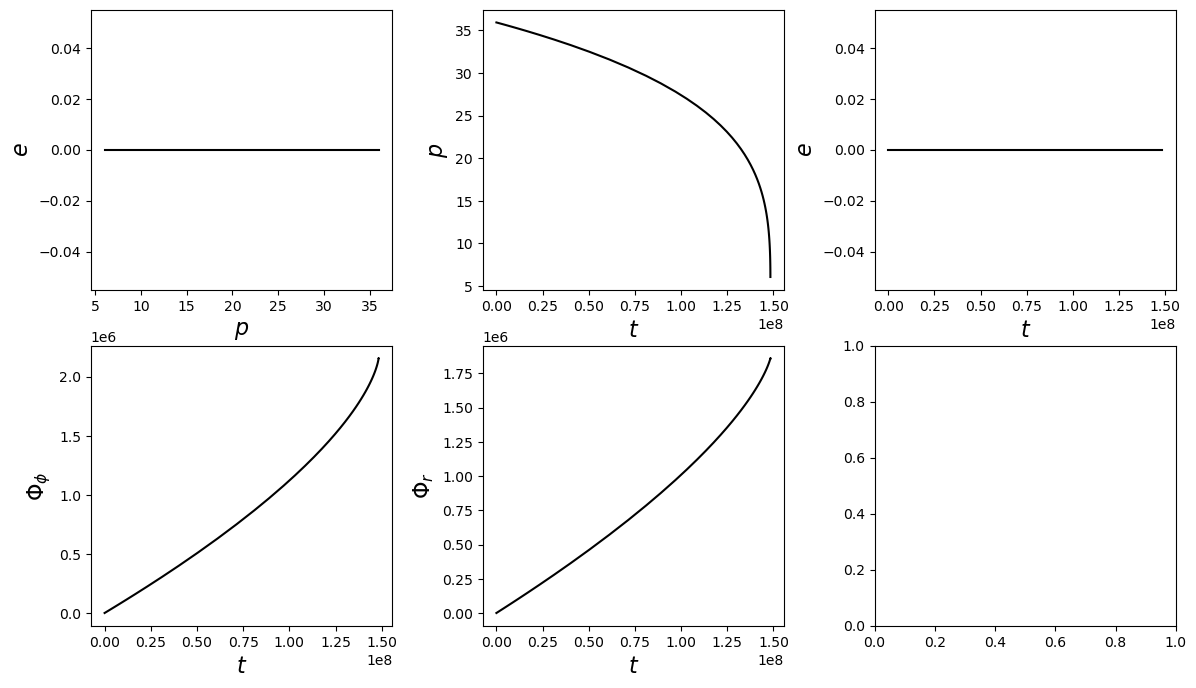

In [18]:
# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun
p0 = 35.93515813204665
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

N_r = 100
evol_factor_init = np.ones(N_r)

dynamic_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, evol_factor_init, T=T, dt=10.0)
t_s, p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s = dynamic_spike_traj
# spline the results
spline_s = CubicSplineInterpolant(t_s, np.stack((p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_s, p_s, e_s, Phi_phi_s, Phi_r_s]
xs = [p_s, t_s, t_s, t_s, t_s]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Number of orbits =  0
Total time [days] =  0.15429862416974358
Number of orbits =  0
Total time [days] =  0.15429862037061656
Number of orbits =  0
Total time [days] =  0.15429860744882307
Number of orbits =  0
Total time [days] =  0.1542985669320636
Number of orbits =  1
Total time [days] =  0.15429846194454522
Number of orbits =  2
Total time [days] =  0.15429818955965502
Number of orbits =  6
Total time [days] =  0.154297529045594
Number of orbits =  18
Total time [days] =  0.15429596592498004
Number of orbits =  55
Total time [days] =  0.38572795087184164
Number of orbits =  227
Total time [days] =  1.5427718356135085
Number of orbits =  1297
Total time [days] =  9.253167456672191
Number of orbits =  11657
Total time [days] =  88.48684304373519
Number of orbits =  19200
Total time [days] =  143.33843111093026
Number of orbits =  21015
Total time [days] =  153.08677807148607
Number of orbits =  21283
Total time [days] =  147.06867954363963
Number of orbits =  20874
Total time [days]

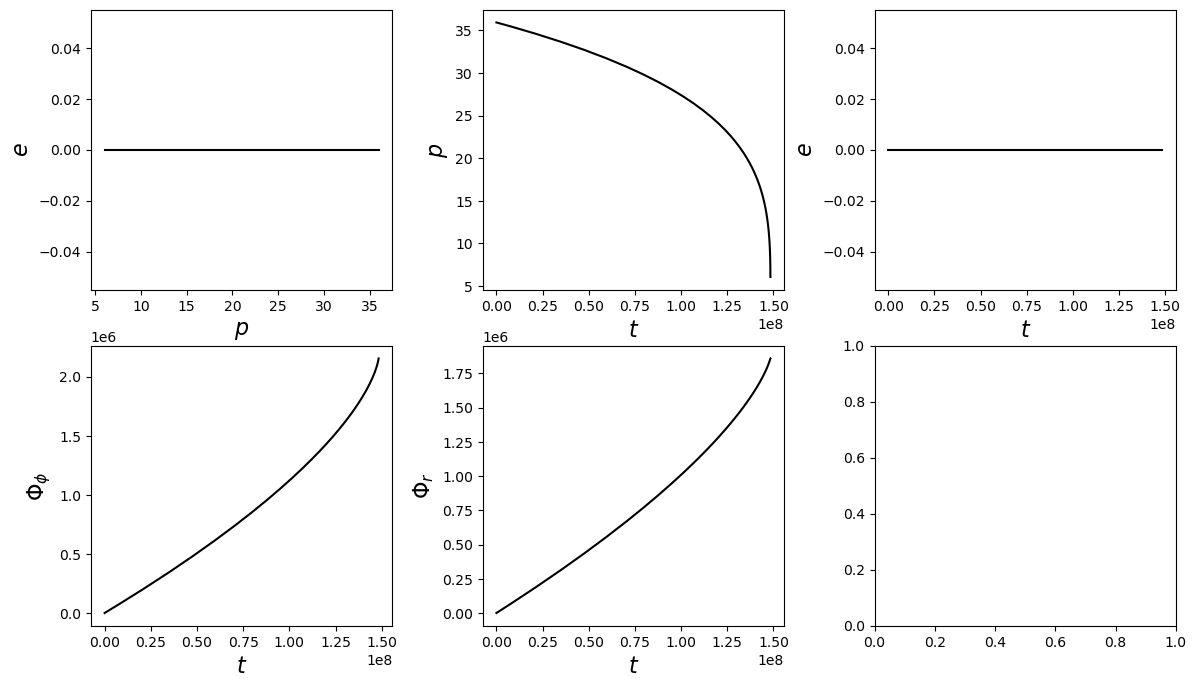

In [19]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

N_r = 100
evol_factor_init = np.ones(N_r)

no_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, evol_factor_init, T=T, dt=10.0)
t, p, e, x, Phi_phi, Phi_theta, Phi_r = no_spike_traj
# spline the results
spline = CubicSplineInterpolant(t, np.stack((p, e, x, Phi_phi, Phi_theta, Phi_r)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r]
xs = [p, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'p')

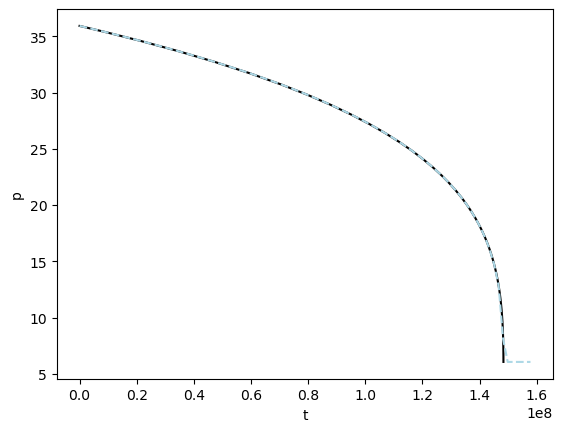

In [20]:
plt.plot(t, p, color='k')
#newt = np.linspace(0.0, T*YRSID_SI,num=100)

plt.plot(newt, spline(newt)[0],'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, '$p$ $[pc]$')

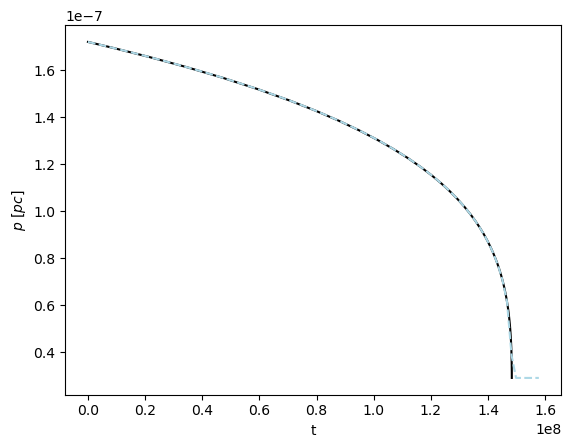

In [21]:
p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
plt.plot(t, p_pc, color='k')
#newt = np.linspace(0.0, T*YRSID_SI,num=100)
sp_p_pc = (spline(newt)[0]*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

plt.plot(newt, sp_p_pc,'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('$p$ $[pc]$')

Text(0, 0.5, 'Number of cucles')

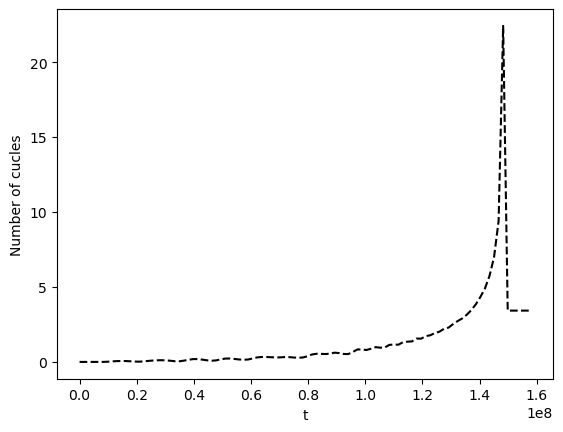

In [22]:
plt.figure()
# the time is store in the spline
plt.plot(newt, np.abs(spline(newt)[4]-spline_s(newt)[4])/(2*np.pi),'--', color='k')
plt.xlabel('t')
plt.ylabel('Number of cucles')
# should be fig 5 https://arxiv.org/pdf/2211.01362.pdf

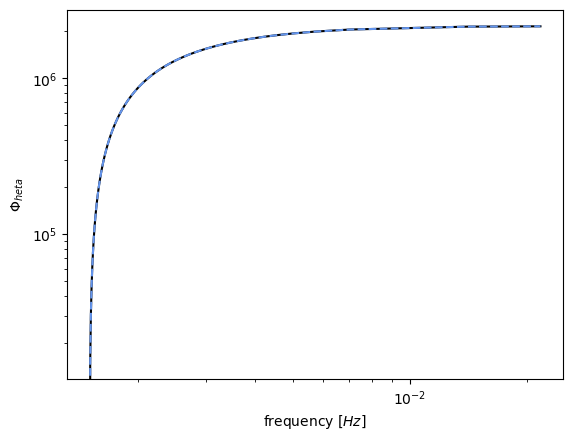

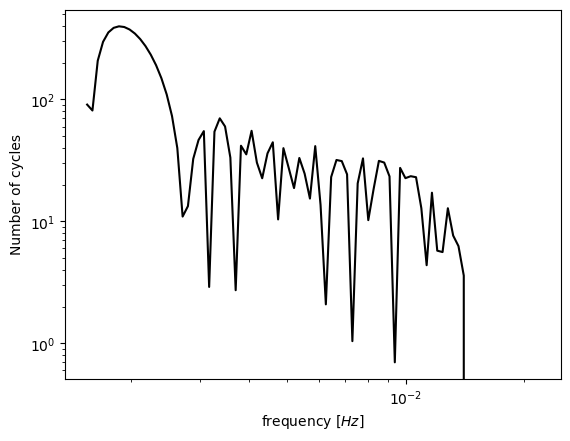

In [23]:
# omega = p**(-3/2)
# no spike
ff = spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase = spline(newt)[4]
spl_phase = CubicSplineInterpolant(ff, phase)
# spike
ff_sp = spline_s(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase_sp = spline_s(newt)[4]
spl_phase_sp = CubicSplineInterpolant(ff_sp, phase_sp)

freq = 10**np.linspace(-3,np.log10(np.max(ff)),num=100)

plt.figure()
# the time is store in the spline
plt.loglog(ff, phase, color ='k')
plt.loglog(ff_sp, phase_sp,'--', color='cornflowerblue')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(spl_phase(freq)-spl_phase_sp(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

The last plot of the following 3 shows the difference between the evolving and the static spike. The number of cycles is reduced by $\sim 10$, showing the importance of feedback from the DM spike on the expected dephasing.

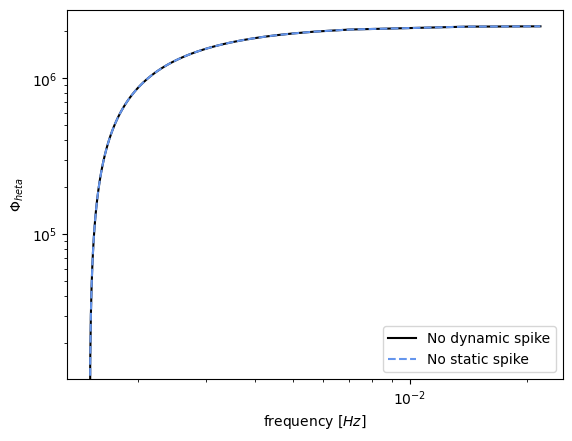

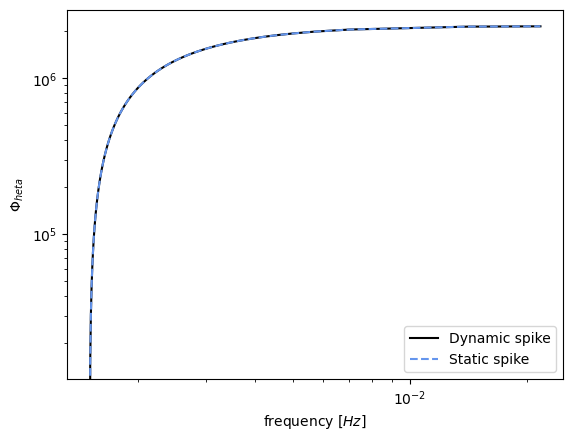

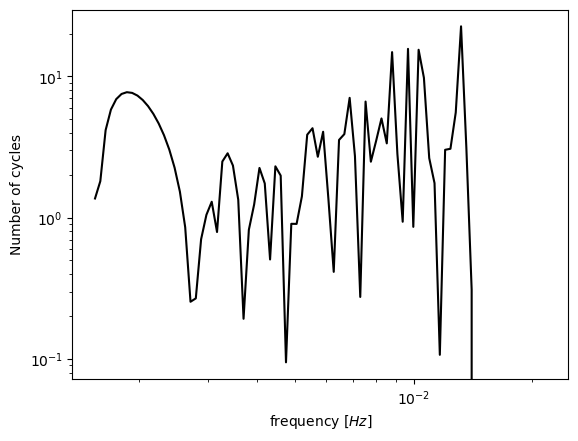

In [24]:
# No spike 
plt.figure()
# the time is stored in the spline
plt.loglog(ff, phase, color ='k', label='No dynamic spike')
plt.loglog(no_stat_sp_ff, no_stat_sp_phase, '--', color='cornflowerblue', label='No static spike')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.legend()
plt.show()

# Dynamic vs Static spike
plt.figure()
# the time is stored in the spline
plt.loglog(ff_sp, phase_sp, color='k', label='Dynamic spike')
plt.loglog(ff_stat_sp, phase_stat_sp,'--', color='cornflowerblue', label='Static spike')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.legend()
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(stat_sp_spl_phase(freq)-spl_phase_sp(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

### Ploting the energy and angular momentum losses.

In [25]:
class Evolution:
    def __init__(self, rho_sp):
        self.rho_sp = rho_sp

    def __call__(self, p_init, e_init, t_init, p, e, t, M, mu, rho_sp, gamma_sp, evol_factor_init):

        rho_sp = self.rho_sp

        # evolving the spike
        sp_evol = spike_evolution(p_init, e_init, t_init, p, e, t, M, mu, rho_sp, gamma_sp, evol_factor_init, DMS=None)
        evol_factor_apo = sp_evol[0]
        evol_factor = sp_evol[1]
        dEdt_DF_circ = sp_evol[2]

        # DF losses
        EdotDF = dEdt_DF_ecc_evol(M, mu, p, e, gamma_sp, rho_sp, evol_factor_apo)
        LdotDF = dLdt_DF_ecc_evol(M, mu, p, e, gamma_sp, rho_sp, evol_factor_apo)

        ELdot_DF = [EdotDF, LdotDF]

        return ELdot_DF, evol_factor_apo, evol_factor, dEdt_DF_circ
    
    

In [26]:

# Testing the DF losses for one simplistic trajectory (p,t)[N_p], e = 0 
N_p = 100
p_init_create = 10**np.linspace(1, 4, N_p)
p_init = np.flip(p_init_create)
p_evol = np.roll(p_init, shift=-1)
p_evol[-1] = p_evol[-2] - 0.00001
#print('p_init =', p_init)
#print('p_evol =', p_evol)


e_init = 0.0
e = 0.0

M = 1e5 # M_sun
mu = 1e1 # M_sun
epsilon = mu/M
gamma_init = 7/3
evol_factor_apo_init = 1.0
rho_sp = 226 # M_sun/pc^3
r_sp_init = (((3-gamma_init)* 0.2**(3-gamma_init) * M)/(2 * np.pi * rho_sp))**(1/3) # pc
#print('r_sp_init = ', r_sp_init)

N_r = 100

# Initialize T
T = 5.0 * 365.25 * 24 * 3600  # 5 years in seconds

# Initialize t_init with T and create t_evol accordingly
t_init = np.array([T])  # Start with T

for i in range(1, N_p):
    dt = (p_init[i] - p_evol[i]) / p_evol[i]
    t_init = np.append(t_init, t_init[-1] - dt*t_init[-1])

# Reverse the arrays to have them in increasing order
t_init = np.flip(t_init)
t_evol = np.roll(t_init, shift=-1)
t_evol[-1] = t_evol[-2]  # Set the last element as the second-to-last
# that is why we take the second-to-final column of densities

# print("t_init:", t_init)
# print("t_evol:", t_evol)

G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
c = 2.99792458e5  # km/s

evol_factor_init = np.ones(N_r)

evol = Evolution(rho_sp)

Edot_DF_list = []
Ldot_DF_list = []

Edot_GW_list = []
Ldot_GW_list = []

evol_factor_apo_list = []
evol_factor_list = []

dEdt_DF_circ_list = []


for i, p_in in enumerate(p_init):
    # Use p_init[i] for each iteration
    p_evol_i = p_evol[i]
    t_init_i = t_init[i]
    t_evol_i = t_evol[i]
    ELdot_DF, evol_factor_apo, evol_factor, dEdt_DF_circ = evol(p_in, e_init, t_init_i, p_evol_i, e, t_evol_i, M, mu, rho_sp, gamma_sp, evol_factor_init)
    Edot_DF = ELdot_DF[0] * 0.50 # matching the circular - 0.58 calibration - 
    Ldot_DF = ELdot_DF[1] * 0.50 # matching the circular - 0.58 calibration -
    Edot_DF_list.append(Edot_DF)
    Ldot_DF_list.append(Ldot_DF)
    evol_factor_apo_init = evol_factor_apo
    evol_factor_apo_list.append(evol_factor_apo)
    evol_factor_init = evol_factor
    evol_factor_list.append(evol_factor)
    # print('evol_factor_array_init = ', evol_factor_array_init)
    ELdot_GW = Edot_GW(p_evol_i, e)
    E_dot_GW = Edot_GW(p_evol_i, e)[0]
    # E_dot_GW = ((32 * G_N**4 * (M + mu) * (M * mu)**2)/(5 * (c * ((p_evol_i*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI) )**5)) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    Ldot_GW = Edot_GW(p_evol_i, e)[1]
    Edot_GW_list.append(E_dot_GW)
    Ldot_GW_list.append(Ldot_GW)
    dEdt_DF_circ_list.append(dEdt_DF_circ * 10**6 /(Power(C_SI,2) * MTSUN_SI * M))

# print('evol_factor_apo_list:', evol_factor_apo_list)
# print('evol_factor_list =', evol_factor_list)

# print(np.shape(Edot_DF_list), Edot_DF_list)
# print(np.shape(Ldot_DF_list), Ldot_DF_list)

# print(np.shape(Edot_GW_list), Edot_GW_list)
# print(np.shape(Ldot_GW_list), Ldot_GW_list)

# print(np.shape(dEdt_DF_circ_list), dEdt_DF_circ_list)

Edot_DF_array = np.array(Edot_DF_list)
Ldot_DF_array = np.array(Ldot_DF_list)
Edot_GW_array = np.array(Edot_GW_list)
Ldot_GW_array = np.array(Ldot_GW_list)

dEdt_DF_circ_array = np.array(dEdt_DF_circ_list)

# ELdot_DF_array has shape (N_p, 2)
# print(np.shape(Edot_DF_array), Edot_DF_array)
# print(np.shape(Ldot_DF_array), Ldot_DF_array)
# print(np.shape(Edot_GW_array), Edot_GW_array)
# print(np.shape(Ldot_GW_array), Ldot_GW_array)

# Calculate Eratio and Lratio
Eratio = Edot_DF_array / Edot_GW_array
Lratio = Ldot_DF_array / Ldot_GW_array

# Stack Eratio and Lratio horizontally to create a (N_p, 2) array
ratios = np.column_stack((Eratio, Lratio))
# print(np.shape(ratios), ratios)

circ_ratio = dEdt_DF_circ_array / Edot_GW_array
Edot_circ_ecc_ratio = dEdt_DF_circ_array / Edot_DF_array 



Number of orbits =  0
Total time [days] =  716.2798156516362
Number of orbits =  0
Total time [days] =  645.1016722876328
Number of orbits =  0
Total time [days] =  580.9966419473958
Number of orbits =  0
Total time [days] =  523.2618553864841
Number of orbits =  0
Total time [days] =  471.26428886880933
Number of orbits =  0
Total time [days] =  424.4338234801921
Number of orbits =  0
Total time [days] =  382.2569941516686
Number of orbits =  0
Total time [days] =  344.27135985473177
Number of orbits =  0
Total time [days] =  310.0604332414117
Number of orbits =  0
Total time [days] =  279.24911413606395
Number of orbits =  0
Total time [days] =  251.49957681011654
Number of orbits =  0
Total time [days] =  226.50756594646958
Number of orbits =  0
Total time [days] =  203.99906068124434
Number of orbits =  0
Total time [days] =  183.7272701463095
Number of orbits =  0
Total time [days] =  165.46992757069356
Number of orbits =  0
Total time [days] =  149.02685327249736
Number of orbits

[1.02389814 1.02388697 1.02387539 1.02386324 1.02385047 1.02383689
 1.02382269 1.02380777 1.023792   1.02377533 1.0237577  1.0237389
 1.02371908 1.02369806 1.02367573 1.023652   1.02362675 1.02359985
 1.02357122 1.02354076 1.02350828 1.02347365 1.02343671 1.02339729
 1.02335518 1.02331025 1.02326227 1.02321101 1.02315623 1.02309768
 1.02303508 1.02296814 1.02289657 1.02282002 1.02273814 1.02265054
 1.02255682 1.02245652 1.0223492  1.02223436 1.02211144 1.02197988
 1.02183907 1.02168833 1.02152698 1.02135427 1.02116939 1.02097148
 1.02075962 1.02053284 1.02029008 1.02003024 1.0197521  1.01946778
 1.01914921 1.01882165 1.01847014 1.01809317 1.01768899 1.0172693
 1.01671146 1.0162039  1.01572674 1.01514572 1.01458521 1.01398208
 1.01333197 1.01263152 1.01193733 1.01118223 1.01036525 1.00954331
 1.00865776 1.00767224 1.00687203 1.00587007 1.00505272 1.00413978
 1.00315721 1.00233888 1.00154266 1.00077783 1.00017961 0.99961295
 0.99929803 0.99819002 0.99844087 0.9992457  0.99995725 1.001778

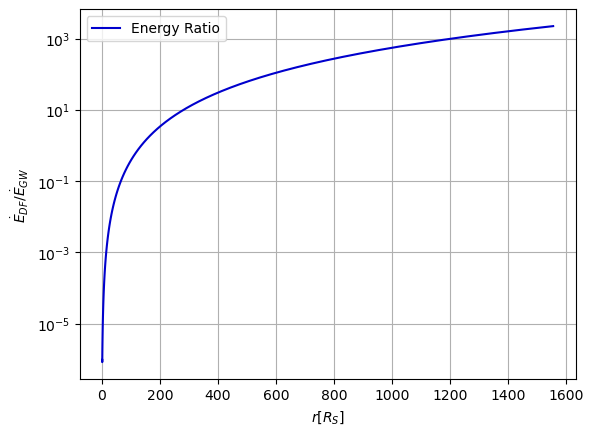

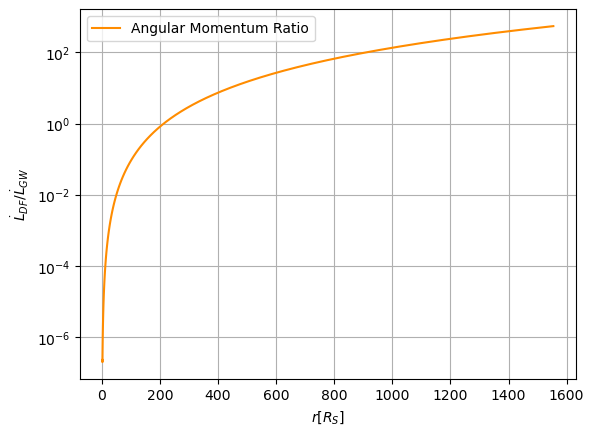

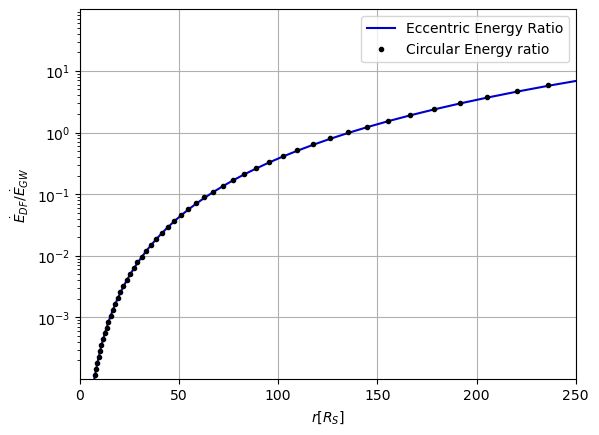

In [27]:
print(Edot_circ_ecc_ratio)

plt.figure()
plt.semilogy(p_evol/6, Eratio, label='Energy Ratio', color='mediumblue')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
#plt.xlim([0, 250])
#plt.ylim([10**(-5), 100])
#plt.yticks([10**i for i in range(-7, 2)])
plt.legend()
plt.show()

plt.figure()
plt.semilogy(p_evol/6, Lratio, label='Angular Momentum Ratio', color='darkorange')
plt.ylabel('$\dot{L}_{DF}/\dot{L}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
#plt.xlim([0, 250])
#plt.ylim([10**(-5), 100])
#plt.yticks([10**i for i in range(-7, 2)])
plt.legend()
plt.show()

plt.figure()
plt.semilogy(p_evol/6, Eratio, label='Eccentric Energy Ratio', color='mediumblue')
plt.semilogy(p_evol/6, circ_ratio, '.', label='Circular Energy ratio', color='k')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-4), 100])
plt.yticks([10**i for i in range(-3, 2)])
plt.legend()
plt.show()

Helpfull to understand the difference in the waveform from the non-relativistic pydd and the highly relativistic FEW.

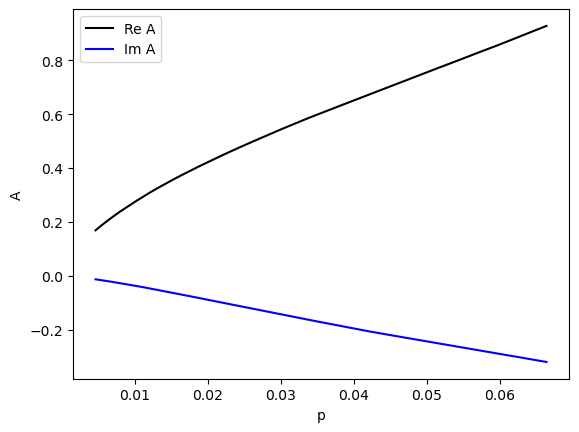

In [28]:
M = 1e5
mu = 1e1
#p0 = 20
p0 = 35.93515813204665
e0 = 0.0
theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc
rho_sp = 226
gamma_sp = 7.0/3
T = 5.0
dt = 10.0

traj = EMRIInspiral(func="SchwarzEccFlux")
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=5.0)


from few.amplitude.romannet import RomanAmplitude
amp = RomanAmplitude(max_init_len=5000)
teuk_modes = amp(p, e)
plt.figure()
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].real, label='Re A', color='k')
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].imag, label='Im A', color='blue')
plt.ylabel('A')
plt.xlabel('p')
plt.legend()
plt.show()

### From Trajectories to Waveforms for EMRIs embedded in evolving DM spikes ###
The following class generates GWs in the time domain using the trajectory module DF_evol_Trajectory introduced above.
Here we use the official SchwarzschildEccentricWaveformBase of the FEW package. 
This limits the initial semi-latus rectum to 10 <= p0 <= 16 + 2 * e.


In [29]:
class ApproxSchwarzschildEccentricFluxDF(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            DF_evol_Trajectory, # here it is the new trajectory!
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

p0[pc] =  7.178140312382814e-08
Number of orbits =  0
Total time [days] =  0.0416120969586496
Number of orbits =  0
Total time [days] =  0.04161205874743801
Number of orbits =  0
Total time [days] =  0.041611934144789454
Number of orbits =  1
Total time [days] =  0.04161156670454753
Number of orbits =  4
Total time [days] =  0.041610558816387096
Number of orbits =  21
Total time [days] =  0.041607229761382446
Number of orbits =  123
Total time [days] =  0.2079637977729681
Number of orbits =  1239
Total time [days] =  2.4904567987411177
Number of orbits =  1869
Total time [days] =  3.6573870221623945
Number of orbits =  2017
Total time [days] =  3.9285039689310666
Number of orbits =  2027
Total time [days] =  3.7773711762644826
Number of orbits =  1966
Total time [days] =  3.438616589198154
Number of orbits =  1653
Total time [days] =  2.768186704414595
Number of orbits =  1533
Total time [days] =  2.4907620795799836
Number of orbits =  1411
Total time [days] =  2.230759733052376
Number

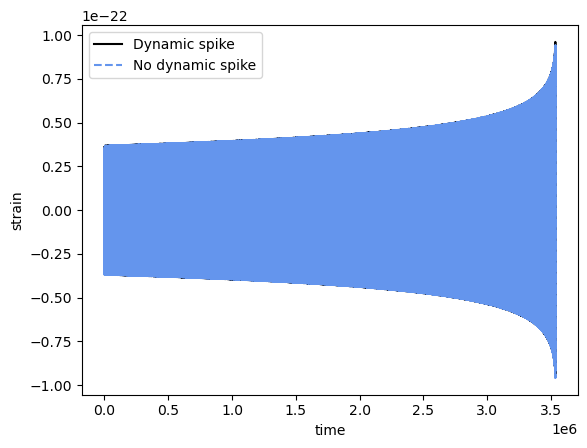

In [30]:
test = ApproxSchwarzschildEccentricFluxDF()

# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun

# comparison paper value
# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)
# p0 = 35.93515813204665
# need to either use frequency domain or use fastinterp.py to import SchwarzschildEccentricWaveformBase

p0 = 15
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc

dt = 10.0

specific_modes = (2,2,0)

N_r = 100
evol_factor_init = np.ones(N_r)

# waveform with spike
wave_sp = test(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, evol_factor_init, dist=dist, dt=dt, T=T)
time_sp = np.arange(0, len(wave_sp))*dt

rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


# waveform without spike
wave = test(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, evol_factor_init, dist=dist, dt=dt, T=T)
time = np.arange(0, len(wave))*dt

plt.plot(time_sp, wave_sp.real, color='k', label='Dynamic spike')
plt.plot(time, wave.real, '--', color='cornflowerblue', label='No dynamic spike')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

Get the overlap and mismatch between the GWs of the evolving spike environment and vacuum around the EMRI.

In [31]:
overlap = get_overlap(wave_sp, wave)
print('O = ' ,overlap)

mismatch = get_mismatch(wave_sp, wave)
print('M = ', mismatch)

O =  0.9948707341010148
M =  0.005129265898985214


### From Trajectories to Waveforms for EMRIs embedded in static DM spikes ###
The following class generates GWs in the time domain using the trajectory module DFTrajectory introduced above.
Here we use the official SchwarzschildEccentricWaveformBase of the FEW package. 
This limits the initial semi-latus rectum to 10 <= p0 <= 16 + 2 * e.

In [32]:
class static_ApproxSchwarzschildEccentricFluxDF(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            DFTrajectory, # here it is the new trajectory!
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

p0[pc] =  7.178140312382814e-08


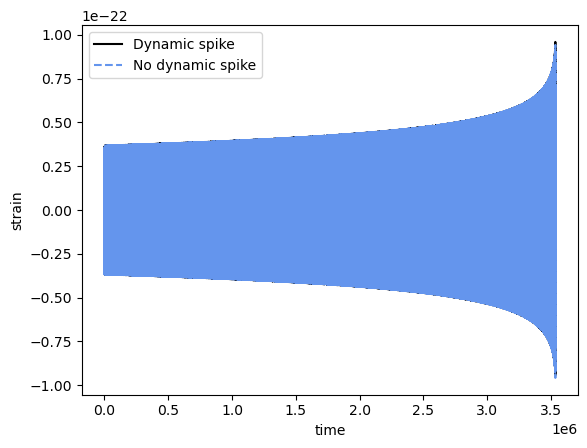

In [33]:
test_static = static_ApproxSchwarzschildEccentricFluxDF()

# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun

# comparison paper value
# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)
# p0 = 35.93515813204665
# need to either use frequency domain or use fastinterp.py to import SchwarzschildEccentricWaveformBase

p0 = 15
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc

dt = 10.0

specific_modes = (2,2,0)

# waveform with spike
wave_static_sp = test_static(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, dist=dist, dt=dt, T=T)
time_static_sp = np.arange(0, len(wave_sp))*dt

rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


# waveform without spike
wave_static = test_static(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, dist=dist, dt=dt, T=T)
time_static = np.arange(0, len(wave))*dt

plt.plot(time_sp, wave_static_sp.real, color='k', label='Dynamic spike')
plt.plot(time, wave_static.real, '--', color='cornflowerblue', label='No dynamic spike')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

In [34]:
overlap = get_overlap(wave_static_sp, wave_static)
print('O = ' ,overlap)

mismatch = get_mismatch(wave_static_sp, wave_static)
print('M = ', mismatch)

O =  0.9781718259543141
M =  0.021828174045685933


Get the overlap and mismatch for the two vacuum waveforms.

In [35]:
overlap_vacuum = get_overlap(wave_static, wave)
mismatch_vacuum = get_mismatch(wave_static, wave)
print('O_v = ', overlap_vacuum)
print('M_v = ', mismatch_vacuum)

O_v =  0.8525294824952264
M_v =  0.14747051750477358


Get the overlap and mismatch for the static and dynamic spike waveforms.

In [36]:
overlap_sp= get_overlap(wave_static_sp, wave_sp)
mismatch_sp = get_mismatch(wave_static_sp, wave_sp)
print('O_sp = ', overlap_sp)
print('M_sp = ', mismatch_sp)

O_sp =  0.8460115734755199
M_sp =  0.15398842652448008


## Density plots ##

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


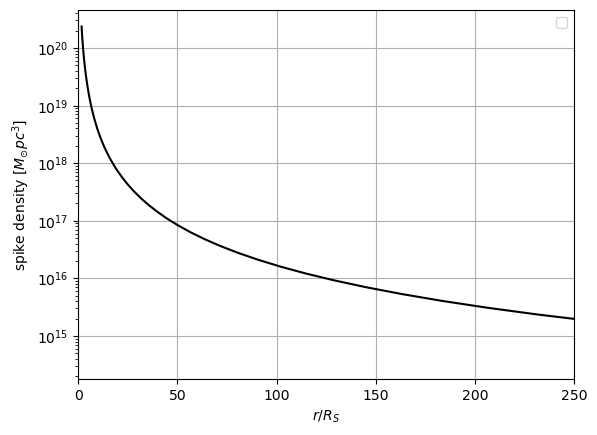

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


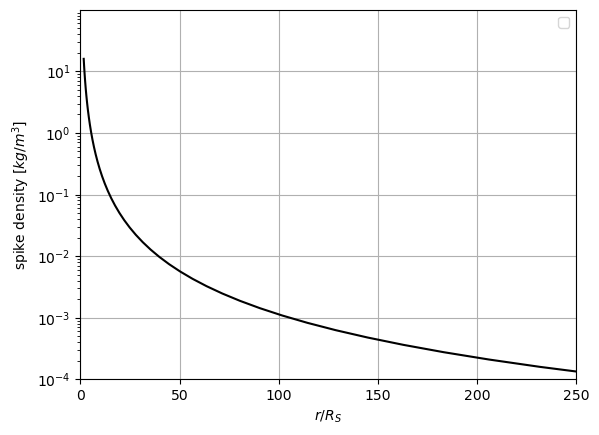

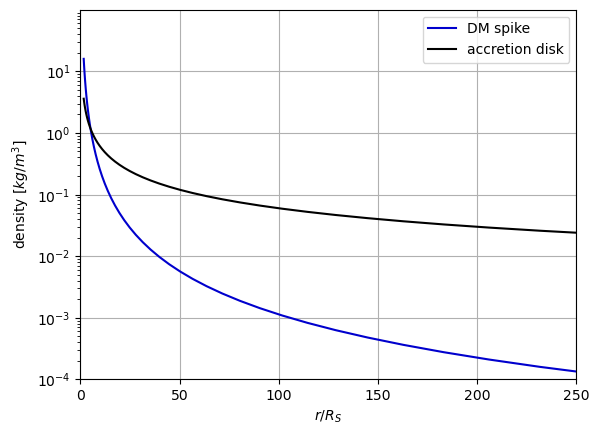

In [38]:
ptest = 10**np.linspace(1, 3.5)
M = 1e5
rho_sp = 226
gamma_sp = 7.0/3
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3)

pc_to_km = 3.08567758149137e13
pc_to_m = 3.08567758149137e16
#r_t = 1e-5 * r_sp * (100 * MSUN_SI/ M)**3/2
alpha = 2
#rho_6 = 1.17 * 1e17
#r_6 = 1e-6

sigma0 = 1.5 * 1e10 

#print((16*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI)

rho_list = []
rho_kg_m3_list =[]
#rho_t_list = []
#rho_rho6_list = []
rho_sigma_list = []

for pp in ptest:
    p_pc = (pp*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
    rho = rho_sp * (r_sp/p_pc)**gamma_sp
    rho_kg_m3 = rho * (MSUN_SI / (pc_to_m**3))
    #rho_t = (rho_sp * (r_sp/p_pc)**gamma_sp)/((1+p_pc/r_t)**alpha) * (1.989e+30 / (3.08567758149137e16**3))
    rho_list.append(rho)
    rho_kg_m3_list.append(rho_kg_m3)
    #rho_t_list.append(rho_t)
    #rho_rho6 = (rho_6 * (r_6/p_pc)**gamma_sp) * (1.989e+30 / (3.08567758149137e16**3))
    #rho_rho6_list.append(rho_rho6) 
    rho_sigma = sigma0/(2*p_pc*pc_to_m) * (pp/(3*pp/6))**(-1/2)
    rho_sigma_list.append(rho_sigma)

plt.figure()
plt.semilogy(ptest/6, rho_list, color='k')
plt.xlabel('$r/R_S$')
plt.ylabel('spike density $[M_{\odot} pc^3]$')
plt.grid()
plt.xlim([0, 250])
plt.legend()
plt.show()

plt.figure()
plt.semilogy(ptest/6, rho_kg_m3_list, color='k')
plt.xlabel('$r/R_S$')
plt.ylabel('spike density $[kg/m^3]$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-4), 100])
plt.yticks([10**i for i in range(-4, 2)])
plt.legend()
plt.show()

plt.figure()
plt.semilogy(ptest/6, rho_kg_m3_list, label='DM spike', color='mediumblue')
plt.semilogy(ptest/6, rho_sigma_list, label='accretion disk', color='k')
plt.xlabel('$r/R_S$')
plt.ylabel('density $[kg/m^3]$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-4), 100])
plt.yticks([10**i for i in range(-4, 2)])
plt.legend()
plt.show()


### Waveforms in the Frequency Domain ###
## NOT READY ##

In [ ]:
for p in sys.path: print(p)

import time, h5py
import corner

from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = DFTrajectory()

from few.utils.utility import cuda_set_device

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from FDutils import *

try:
    import cupy as xp
    # set GPU device
    os.system(f"CUDA_VISIBLE_DEVICES=0")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")

few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean


# fontsize label
fs_lab = 18
# legend
fs_leg = 14
# ticks
fs_ticks = 14
mpl.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "figure.figsize": [default_width, default_width * default_ratio],
  'legend.fontsize': fs_leg,
  'xtick.labelsize': fs_ticks,
  'ytick.labelsize': fs_ticks,
})



In [ ]:
# define the injection parameters
M = 1e5 # M_sun
mu = 1e1 # M_sun

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)
# p0 = 35.93515813204665
# need to either use frequency domain or use fastinterp.

p0 = 15
e0 = 0.0

a = 0.0 # will be ignored in Schwarzschild waveform
x0 = 1.0

qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 3.3 # luminosity distance in Gpc

# initial phases
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0
#theta = 0
#phi = 0

Tobs = 5.0 # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
traj_module,
Tobs*0.99,
[M, mu, 0.0, e0, 1.0, gamma_sp, rho_sp, r_sp],
index_of_p=3,
index_of_a=2,
index_of_e=4,
index_of_x=5,
traj_kwargs={},
xtol=2e-12,
rtol=8.881784197001252e-16,
bounds=None,
)


